# Project - Hourly Energy Consumption Analysis and Forecasting
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. The hourly energy consumption data is available on PJM's website. The data set is also available part of Kaggle competition on Hourly Energy Consumption. This project first analyzes the energy consumption data of PJM East region (2001-2018) and than applies XGBoost forecasting algorithm.

# Business Understanding
Following queries are addressed through this work. 
## Energy Analytics
### Question 1: What is the trend of energy consumption at PJM East over the years from 2002 - 2018?
### Question 2: What is the typical trend of energy consumption at PJM East over months in a year?
### Question 3: What is the variation in energy consumption at PJM East through out a day?
## Energy Forecasting
### Question 4: What are the significant features influencing the forecasting performance?
### Question 5: How acurately XGBoost can forecast the energy consumption ?

In [3]:
#Import Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

## Data Understanding

In [4]:
#Read in PJM Hourly Power Consumption data file to dataframe df
pjme_energy: object = pd.read_csv('PJME_hourly.csv')

## Assess and Explore Data
The dataset has no null values, and is preprocessed already. The Leap year show higher value logs compared to Other years since there is additional day. 2018 shows lower value since the data is unavailable beyond July

In [5]:
# Check number of Columns and Rows
num_rows = pjme_energy.shape[0]  # Provide the number of rows in the dataset
num_cols = pjme_energy.shape[1] #Provide the number of columns in the dataset

print(num_rows, num_cols) 

145366 2


In [6]:
#Check the Data
print(pjme_energy.tail())

                   Datetime  PJME_MW
145361  2018-01-01 20:00:00  44284.0
145362  2018-01-01 21:00:00  43751.0
145363  2018-01-01 22:00:00  42402.0
145364  2018-01-01 23:00:00  40164.0
145365  2018-01-02 00:00:00  38608.0


In [7]:
#Converting Datetime column to datetime %Y-%m-%d %H:%M:%S format
pjme_energy['Datetime'] = pd.to_datetime(pjme_energy.Datetime, format='%Y-%m-%d %H:%M:%S')

In [8]:
#Checking Null values
pjme_energy.isna().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [9]:
# Check Total Value Count for Each Year
Yearly_Value_Counts = pjme_energy['Datetime'].dt.year.value_counts(sort=False)
print(Yearly_Value_Counts)

2002    8757
2003    8758
2004    8782
2005    8758
2006    8758
2007    8758
2008    8782
2009    8758
2010    8757
2011    8758
2012    8782
2013    8758
2014    8760
2015    8760
2016    8784
2017    8760
2018    5136
Name: Datetime, dtype: int64


In [10]:
#Statistics Describing PJME Power Consumption
pjme_statistics = pjme_energy['PJME_MW'].describe().T
print(pjme_statistics)

count    145366.000000
mean      32080.222831
std        6464.012166
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64


In [11]:
# Adding Hour of Day and Month of Year Columns to the Dataframe
pjme_energy['hour'] = pjme_energy.Datetime.dt.hour
pjme_energy['month'] = pjme_energy.Datetime.dt.month

In [12]:
# Calculate Year-wise Energy Consumption Mean and Std deviation
pjme_energy.groupby(pd.Grouper(key='Datetime', freq='Y')).agg({'PJME_MW': ['mean', 'std']})

PJME_MW             
                    mean          std
Datetime                             
2002-12-31  31565.617106  6608.598233
2003-12-31  31698.758621  6034.248413
2004-12-31  32270.434867  6047.557791
2005-12-31  33310.478648  6917.037149
2006-12-31  32409.269696  6586.240497
2007-12-31  33613.468600  6490.877952
2008-12-31  32929.593373  6234.966495
2009-12-31  31851.533683  5902.906901
2010-12-31  33101.172662  6971.797938
2011-12-31  32368.308518  6576.160936
2012-12-31  31440.107265  6515.756495
2013-12-31  31706.525120  6285.566455
2014-12-31  31496.406963  6091.506974
2015-12-31  31709.394178  6597.934042
2016-12-31  31337.833106  6775.022873
2017-12-31  30650.911644  5992.663514
2018-12-31  31782.598715  6279.838832

In [13]:
# Calculate Month-wise Energy Consumption Mean and Std deviation
pjme_energy.groupby(['month']).agg({'PJME_MW': ['mean', 'std']})

PJME_MW             
               mean          std
month                           
1      34343.246462  4850.703528
2      33434.972049  4407.822868
3      30514.903609  4087.417737
4      27863.339354  3848.545984
5      28695.362113  5321.708862
6      33811.799183  7436.621421
7      37881.972881  8077.008457
8      36595.959675  7733.899288
9      31484.054688  6412.991995
10     28119.228675  4290.701799
11     29328.733872  3930.699025
12     32676.247669  4553.541308

In [14]:
# Calculate Hour-wise Energy Consumption Mean and Std deviation
pjme_energy.groupby(['hour']).agg({'PJME_MW': ['mean', 'std']})

PJME_MW             
              mean          std
hour                           
0     29523.611194  4286.936723
1     27535.589964  3987.426313
2     26344.055207  3803.207177
3     25679.097666  3701.133416
4     25414.924728  3665.041944
5     25749.431000  3717.745245
6     27162.853912  3951.723355
7     29611.046880  4551.922318
8     31490.827831  4784.761344
9     32628.888247  4567.131092
10    33497.403433  4599.955913
11    34197.643117  4966.242882
12    34588.618356  5457.510448
13    34759.571146  5949.561322
14    34916.601684  6423.590469
15    34940.669693  6781.758393
16    35065.392209  6984.639645
17    35596.051502  6950.039768
18    36421.931496  6721.220256
19    36426.629911  6249.994420
20    36106.840211  5619.340171
21    35741.057280  5233.332936
22    34453.149884  5079.542072
23    32047.501486  4675.497102

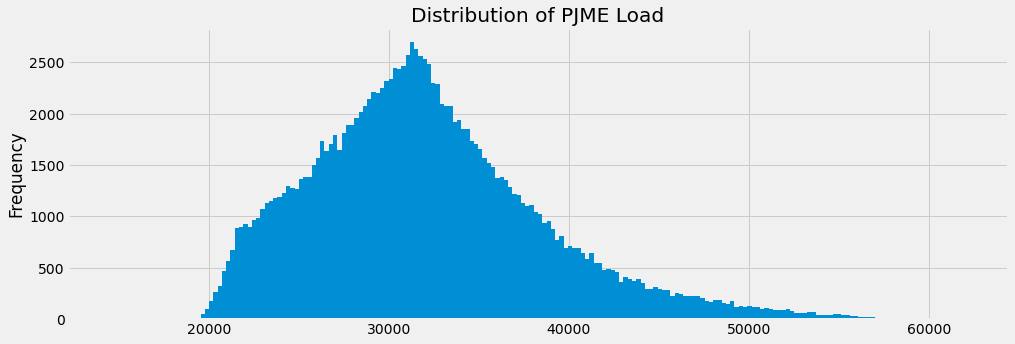

In [15]:
#Histogram of Power Consumption for PJME
pjme_energy['PJME_MW'].plot.hist(figsize=(15, 5), bins=200, title='Distribution of PJME Load')

## Visualize Data

### Question 1: What is the trend of energy consumption at PJM East over the years from 2002 - 2018?
Answer: PJM Energy consumption Load does not show increasing or decreasing trend from 2002-2018. The demand seems to be stagnant overall with Yearly average energy consumption in 30000-330000 MW range.

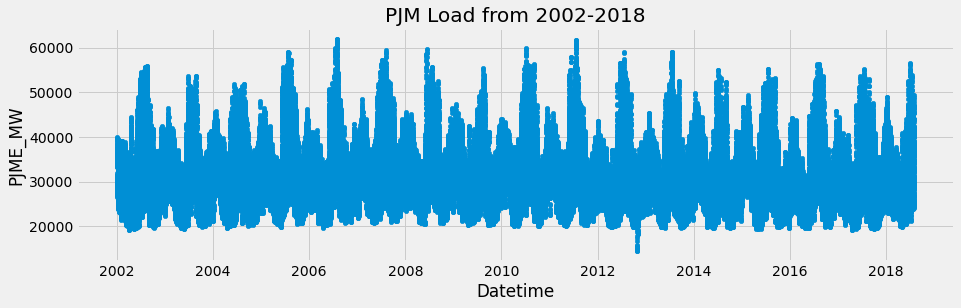

In [16]:
# PJME Power Consumption Trend Chart
pjme_energy[['PJME_MW', 'Datetime']].plot(x='Datetime',
                                          y='PJME_MW',
                                          kind='scatter',
                                          figsize=(14, 4),
                                          title='PJM Load from 2002-2018')

### Question 2: What is the typical trend of energy consumption at PJM East over months in a year?
Answer: The energy consumption trend shows demand peaking in Months Jun-Sep and again a smaller peak in Dec-Feb.
### Question 3: What is the variation in energy consumption at PJM East through out a day?
Answer: The energy consumption is higher during afternoon-evening hours from 2PM - 7PM after which it starts to decrease. Expectedly, the energy consumption is the lowest during night hours 1AM-6AM

(0.0, 65000.0)

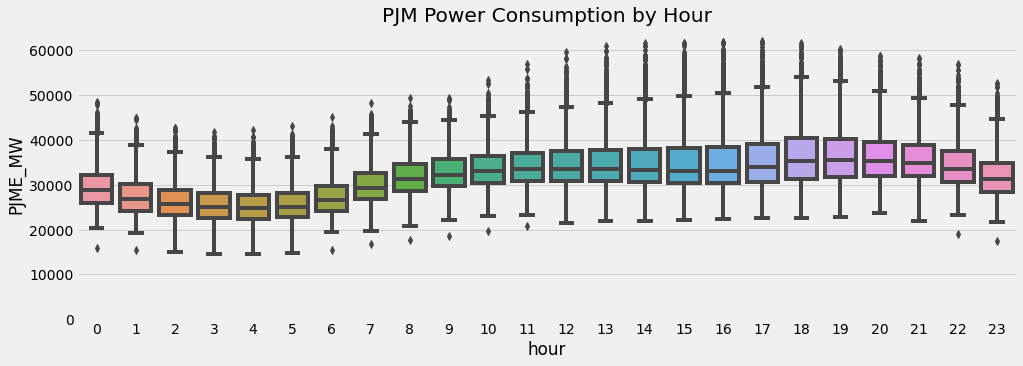

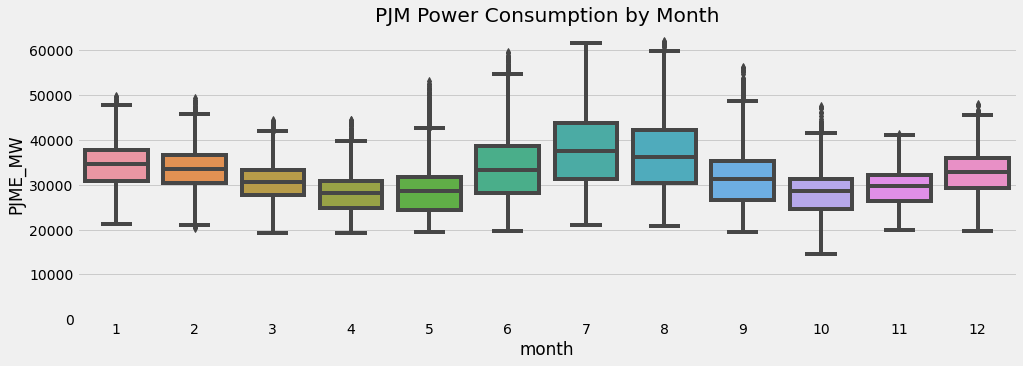

In [17]:
# PJM Power Consumption Box Plot by Hour of Day
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=pjme_energy.hour, y=pjme_energy.PJME_MW)
ax.set_title('PJM Power Consumption by Hour')
ax.set_ylim(0, 65000)

# PJM Power Consumption Box Plot by Month of Year
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=pjme_energy.month, y=pjme_energy.PJME_MW)
ax.set_title('PJM Power Consumption by Month')
ax.set_ylim(0, 65000)

## Forecasting using XGBoost

In [18]:
# Split PJME Energy Conumption Dataset to Train and Test 
SPLIT_DATE = '2015-01-01'
pjme_energy_train = pjme_energy.loc[pjme_energy.Datetime <= SPLIT_DATE].copy()
pjme_energy_test = pjme_energy.loc[pjme_energy.Datetime > SPLIT_DATE].copy()

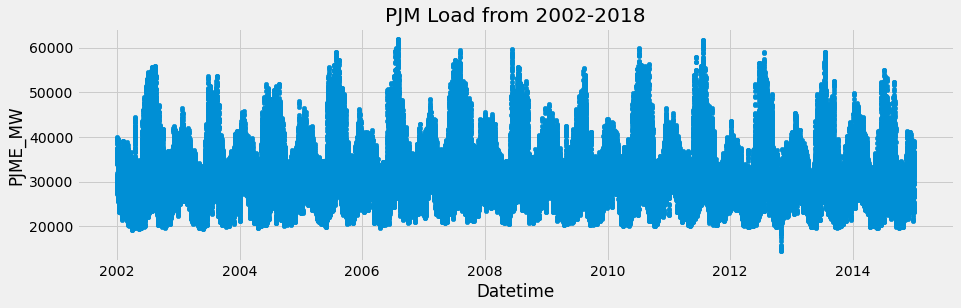

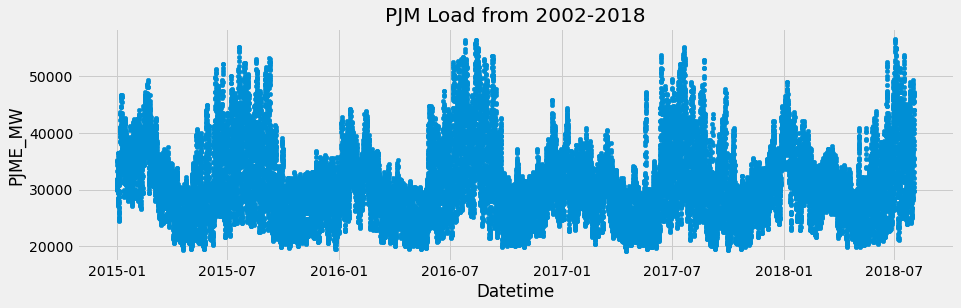

In [19]:
# Plot PJME Energy Conumption Train and Test Datasets
pjme_energy_train[['PJME_MW', 'Datetime']].plot(x='Datetime',
                                                y='PJME_MW',
                                                kind='scatter',
                                                figsize=(14, 4),
                                                title='PJM Load from 2002-2018')
pjme_energy_test[['PJME_MW', 'Datetime']].plot(x='Datetime',
                                               y='PJME_MW',
                                               kind='scatter',
                                               figsize=(14, 4),
                                               title='PJM Load from 2002-2018')

## Data Modeling

In [20]:
# Function to create features 
def create_features(energy_data, label=None):
    """
    Creates time series features from datetime index
    - Feature set 1: date, hour, day of the week, month, quarter, year, day of the year,
      week of the year
    - Feature Set 2: Energy Consumption Lag Features to convert forecasting Labelled,
      supervised ML problem: Lag of 2, 4, 8, 12 and 24 Hours
    - Feature Set 3: Rolling Windows - Fixed size windows (4, 8, 12 and 24 Hour windows)
      over which mean, standard deviation, Maximum and Minimum.
    """
    energy_data['date'] = energy_data.index
    energy_data['hour'] = energy_data['Datetime'].dt.hour
    energy_data['dayofweek'] = energy_data['Datetime'].dt.dayofweek
    energy_data['month'] = energy_data['Datetime'].dt.month
    energy_data['quarter'] = energy_data['Datetime'].dt.quarter
    energy_data['year'] = energy_data['Datetime'].dt.year
    energy_data['dayofyear'] = energy_data['Datetime'].dt.dayofyear
    energy_data['dayofmonth'] = energy_data['Datetime'].dt.day
    energy_data['weekofyear'] = energy_data['Datetime'].dt.weekofyear
    energy_data['pjme_2_hrs_lag'] = energy_data['PJME_MW'].shift(2)
    energy_data['pjme_4_hrs_lag'] = energy_data['PJME_MW'].shift(4)
    energy_data['pjme_8_hrs_lag'] = energy_data['PJME_MW'].shift(8)
    energy_data['pjme_12_hrs_lag'] = energy_data['PJME_MW'].shift(12)
    energy_data['pjme_24_hrs_lag'] = energy_data['PJME_MW'].shift(24)
    energy_data['pjme_4_hrs_mean'] = energy_data['PJME_MW'].rolling(window=4).mean()
    energy_data['pjme_8_hrs_mean'] = energy_data['PJME_MW'].rolling(window=8).mean()
    energy_data['pjme_12_hrs_mean'] = energy_data['PJME_MW'].rolling(window=12).mean()
    energy_data['pjme_24_hrs_mean'] = energy_data['PJME_MW'].rolling(window=24).mean()
    energy_data['pjme_4_hrs_std'] = energy_data['PJME_MW'].rolling(window=4).std()
    energy_data['pjme_8_hrs_std'] = energy_data['PJME_MW'].rolling(window=8).std()
    energy_data['pjme_12_hrs_std'] = energy_data['PJME_MW'].rolling(window=12).std()
    energy_data['pjme_24_hrs_std'] = energy_data['PJME_MW'].rolling(window=24).std()
    energy_data['pjme_4_hrs_max'] = energy_data['PJME_MW'].rolling(window=4).max()
    energy_data['pjme_8_hrs_max'] = energy_data['PJME_MW'].rolling(window=8).max()
    energy_data['pjme_12_hrs_max'] = energy_data['PJME_MW'].rolling(window=12).max()
    energy_data['pjme_24_hrs_max'] = energy_data['PJME_MW'].rolling(window=24).max()
    energy_data['pjme_4_hrs_min'] = energy_data['PJME_MW'].rolling(window=4).min()
    energy_data['pjme_8_hrs_min'] = energy_data['PJME_MW'].rolling(window=8).min()
    energy_data['pjme_12_hrs_min'] = energy_data['PJME_MW'].rolling(window=12).min()
    energy_data['pjme_24_hrs_min'] = energy_data['PJME_MW'].rolling(window=24).min()

    features = energy_data[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'pjme_2_hrs_lag', 'pjme_4_hrs_lag',
            'pjme_8_hrs_lag', 'pjme_12_hrs_lag', 'pjme_24_hrs_lag', 'pjme_4_hrs_mean',
            "pjme_8_hrs_mean", "pjme_12_hrs_mean", "pjme_24_hrs_mean", "pjme_4_hrs_std",
            "pjme_8_hrs_std", "pjme_12_hrs_std", "pjme_24_hrs_std",
            "pjme_4_hrs_max", "pjme_8_hrs_max", "pjme_12_hrs_max", "pjme_24_hrs_max",
            "pjme_4_hrs_min", "pjme_8_hrs_min", "pjme_12_hrs_min", "pjme_24_hrs_min"]]
    if label:
        label = energy_data[label]
        return features, label
    return features

In [21]:
# Create feature set for train and test dataset
pjme_features_train, pjme_label_train = create_features(pjme_energy_train, label='PJME_MW')
pjme_features_test, pjme_label_test = create_features(pjme_energy_test, label='PJME_MW')

In [22]:
#Fit XGB model on the Energy Consumption Dataset
energy_forecasting_model = xgb.XGBRegressor(n_estimators=1000)
energy_forecasting_model.fit(pjme_features_train, pjme_label_train,
                             eval_set=[(pjme_features_train, pjme_label_train),
                                       (pjme_features_test, pjme_label_test)],
                             early_stopping_rounds=50,
                             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluate the Results

### Question 4: What are the significant features influencing the forecasting performance?
Answer: Feature importance plot below shows significant features for forecasting. Lag features of (2 Hour Lag, 24 and 4 Hour lag) are most important alongwith Hour (or time) of day and 4 Hour rolling window statistical variables of mean, standard deviation, Max and min values in that order. 

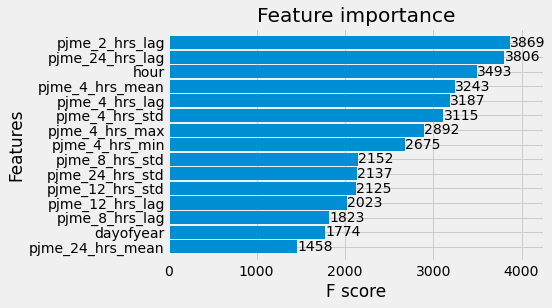

In [23]:
#Plot Top 15 features by Significance for forecasting
_ = plot_importance(energy_forecasting_model, height=0.9, max_num_features=15)

In [24]:
# Predict Energy consumption for 2015-2018 using trained XGB model and set of features used earlier
pjme_energy_test['MW_Prediction'] = energy_forecasting_model.predict(pjme_features_test)
df_all = pd.concat([pjme_energy_test, pjme_energy_train], sort=False)

### Question 5: How acurately XGBoost can forecast the energy consumption?
Answer: The results show XGBoost accurately predicting energy consumption with 0.5% MAPE.

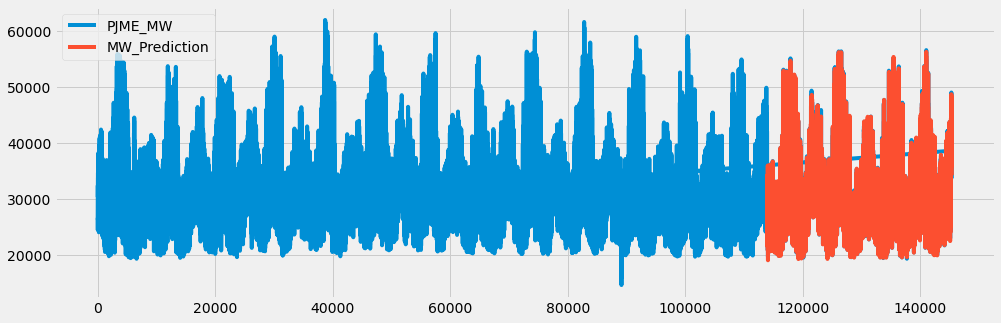

In [25]:
# Plot original and Model-Predicted energy consumption Output for PJME
_ = df_all[['PJME_MW', 'MW_Prediction']].plot(figsize=(15, 5))

In [26]:
# Calculate MSE, MAE and MAPE for Predicted output to quantify model error
mse = mean_squared_error(y_true=pjme_energy_test['PJME_MW'],
                         y_pred=pjme_energy_test['MW_Prediction'])
mae = mean_absolute_error(y_true=pjme_energy_test['PJME_MW'],
                          y_pred=pjme_energy_test['MW_Prediction'])


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(y_true=pjme_energy_test['PJME_MW'],
                                      y_pred=pjme_energy_test['MW_Prediction'])
print(mse,mae,mape)

80528.02528130788 181.97644968232132 0.5855617159848374
